# Spark Funds investment analysis

### Spark Funds is an asset management company. It is looking for investment oppertunities based on the below criteria:
##### 1. The popular investment type where most companies have invested
##### 2. The countries, English speaking, where most companies have invested
##### 3. The industry sectors where most companies have invested.
##### 4. In amounts from 5 million to 15 million USD in each bucket

### Dataset:
##### We have three datasets as follows:
##### 1. The companies list having company permalink, funding round permalink, name , category and country among other variables 
##### 2. The rounds2 list having company permalink, investment type , amount etc among other variables
##### 3. The mapping list which have the industry vs category information

### Approach:
##### I am going to follow the below steps as part of the analysis:
##### 1. Get the files available in a diretory, check for the encoding type and then load it into a dataframe using pandas.
##### 2. Analyse the data I have. Cleaning the data - understand if there are null values and what to do with them, check for errors in data, certain columns if required or not etc
##### 3. Make a consolidated dataframe having only the information relevant to this analysis. This will help in focusing on my goals.
##### 4. Check for outliers, undertand how they needs to be treated, what impact it has on our analysis.
##### 5. Start the analysis with analysing the first requirement that is most invested investment type in the range of 5 million to 15 million USD
##### 6. Analyse the top 9 countries where the above investment type holds the most investment amount
##### 7. From the top 9 countries, we are going to check for top 3 countries, english speaking, who have the most investment.
##### 8. Analyse the Industrial sector, counts, investment amounts and other information in these countries
##### 9. Data Quality summary

In [76]:
#Import all Libraries needed for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from numpy import median

#### 1. Loading files:

In [77]:
#Read the data from csv to dataframe
# I checked the unicode in notepad because it gave the most proper unicode format for the files
# I can see that the companies and rounds2 files are encoded in 'ANSI' unicode format and mapping file in 'UTF-8'
companies = pd.read_csv('C:\\Users\\saifr\\Documents\\Python Data files\\companies.csv',encoding='ANSI')
rounds2 = pd.read_csv('C:\\Users\\saifr\\Documents\\Python Data files\\rounds2.csv',encoding='ANSI')
mapping = pd.read_csv('C:\\Users\\saifr\\Documents\\Python Data files\\mapping.csv',encoding='UTF-8')

In [78]:
#checking how the data looks like at a glance for companies dataframe
companies.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN


In [79]:
#checking how the data looks like at a glance for rounds2 dataframe
rounds2.head(3)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0


In [80]:
#checking how the data looks like at a glance for mapping dataframe
mapping.head(3)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0


#### 2. Data analysis:

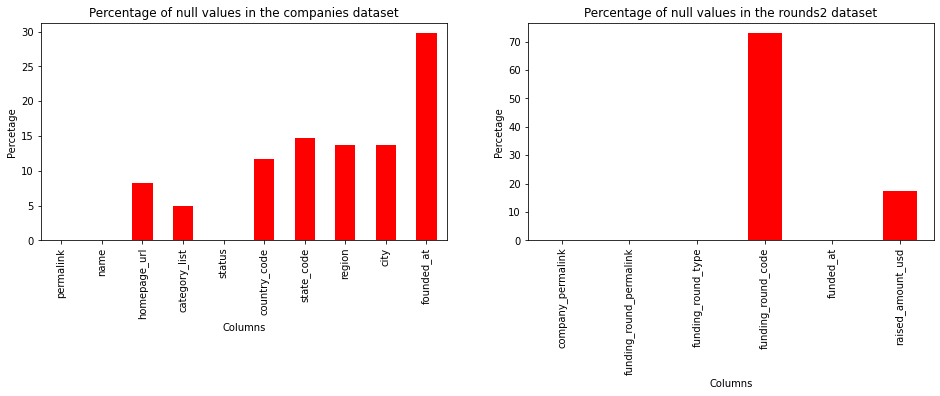

In [81]:
#Let's have a look at the dataset that we have, how many null values
plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
((companies.isnull().sum()/companies.count())*100).plot.bar(color='red').set_title('Percentage of null values in the companies dataset')
plt.ylabel('Percetage')
plt.xlabel('Columns')
plt.subplot(1,2,2)
((rounds2.isnull().sum()/rounds2.funding_round_permalink.count())*100).plot.bar(color='red').set_title('Percentage of null values in the rounds2 dataset')
plt.ylabel('Percetage')
plt.xlabel('Columns')
plt.show()

##### What we can see in the companies files is that the permalink can be used as a unique identifier as it is distinct and represent a company

In [82]:
# To find the number of unique companies from the companies dataset
# This will give us the idea about the companies, categories they belong, the region they are based out of and so on.
companies.permalink.str.lower().nunique()

66368

In [83]:
# Find number of countries
companies['country_code'].nunique()

137

In [84]:
# To find the number of unique companies from the rounds2 dataset
# This will give us the companies and their investment patterns in the past
rounds2.company_permalink.str.lower().nunique()

66368

In [85]:
# Find the unique funding rounds to understand unique fundings to each companies
rounds2['funding_round_permalink'].nunique()

114949

In [86]:
# Find unique funding type
rounds2['funding_round_type'].nunique()

14

##### We can see that the numbers are the same for both the files meaning same number of companies are there in both the files.

In [87]:
# Here we are checking if there are any companies in rounds2 dataset that are not in companies dataset.
rounds2[rounds2.company_permalink.str.lower().isin(companies.permalink.str.lower()) == False].count()

company_permalink          0
funding_round_permalink    0
funding_round_type         0
funding_round_code         0
funded_at                  0
raised_amount_usd          0
dtype: int64

##### We can see, all the companies that are in rounds2 are there in the companies dataset

In [88]:
# Since there are a few companies that are case modified, we are going to convert them to a fixed case so that they are all in the same case
#Converting the key values(company permalink) into one case (lower) to eliminate duplicates
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
companies['permalink'] = companies['permalink'].str.lower()

#### 3. Merging the data

In [89]:
# Merge the two datasets companies and rounds2 based on the key - company permalink
# We are merging the two datasets based on a left outer join on rounds2 on the company permalink
master_frame = pd.merge(rounds2,companies,how='left',left_on='company_permalink',right_on='permalink')

##### This will give us a master file having all the columns in both companies and rounds2 datasets linked together by a common key - company permalink

In [90]:
# We can now check for the number of rows we have for our analysis. For that we are using shape on our master dataset
master_frame.shape

(114949, 16)

##### There are a few columns in the master dataset that are not relevant to the analysis we are doing in this case. So we are going to drop all the columns that we do not need for our analysis so that we can focus more on the elements that we need to analyse

In [91]:
# Dropping all columns that we do not need for this analysis
master_frame.drop(['funding_round_code','funded_at','permalink','homepage_url','state_code','region','city','founded_at'],inplace=True,axis=1)

In [92]:
# So now we have a dataset having the columns that we need for analysis.
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2   funding_round_type       114949 non-null  object 
 3   raised_amount_usd        94959 non-null   float64
 4   name                     114948 non-null  object 
 5   category_list            111539 non-null  object 
 6   status                   114949 non-null  object 
 7   country_code             106271 non-null  object 
dtypes: float64(1), object(7)
memory usage: 7.9+ MB


#### Once we have the master dataset with the columns that we need, now we need to check for null values in the dataset

In [93]:
#check for null values across columns in percentage of total values
round((master_frame.isnull().sum()/len(master_frame.index))*100)

company_permalink           0.0
funding_round_permalink     0.0
funding_round_type          0.0
raised_amount_usd          17.0
name                        0.0
category_list               3.0
status                      0.0
country_code                8.0
dtype: float64

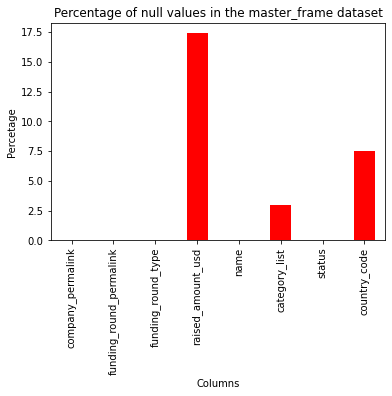

In [94]:
# Graph for null values across columns in percentage of total values
((master_frame.isnull().sum()/master_frame.funding_round_permalink.count())*100).plot.bar(color='red').set_title('Percentage of null values in the master_frame dataset')
plt.ylabel('Percetage')
plt.xlabel('Columns')
plt.show()

##### We can observe that the column raised_amount_usd is having 17% of null value in the dataset. We are analysing the raised amount for different investment types and thus it is necessary that we have a dataset with amounts not equal to null. So, as part of this analysis, we are going to eliminate the rows with null values in raised amount

In [95]:
#Delete rows with null values for raised_amount_usd column
master_frame = master_frame[~(master_frame.raised_amount_usd.isnull())]

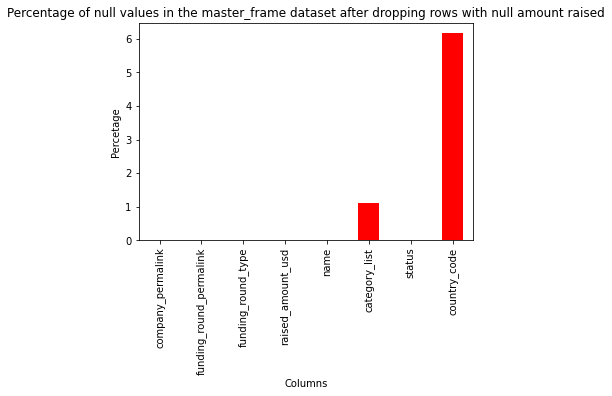

In [96]:
# Checking the dataframe information
((master_frame.isnull().sum()/master_frame.funding_round_permalink.count())*100).plot.bar(color='red').set_title('Percentage of null values in the master_frame dataset after dropping rows with null amount raised')
plt.ylabel('Percetage')
plt.xlabel('Columns')
plt.show()

##### So now we have a dataset that we can use for our analysis of investment type according to our investment criteria. Let's have a look at those investment types that the companies have mostly invested in

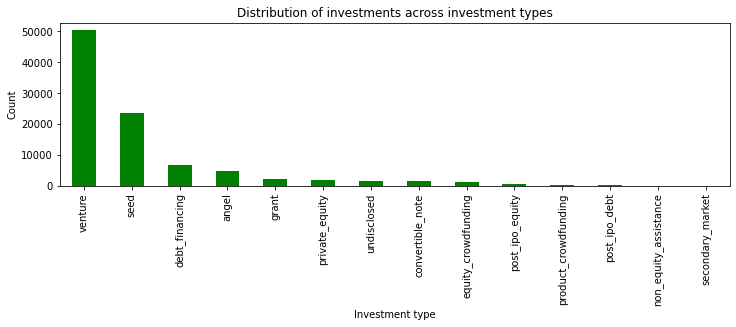

In [97]:
# Investment types that companies have invested in
plt.figure(figsize=[12,3])
master_frame['funding_round_type'].value_counts().plot.bar(color='green').set_title('Distribution of investments across investment types')
plt.xlabel('Investment type')
plt.ylabel('Count')
plt.show()

#### 4. Check for outliers:

##### From the above plot, we can see that the most suited investment for companies is the 'venture' type followed by 'seed', 'angel' and other investment types

##### In the given dataset, in the amount raised columns, we can see that there are values in a wide variety of range. Let's have a look at the distribution of amounts for the four specified investment types

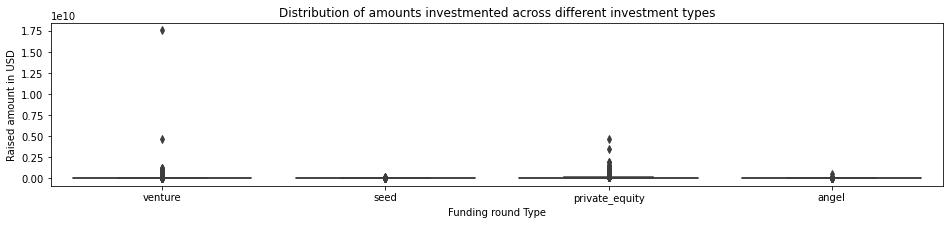

In [98]:
plt.figure(figsize=[16,3])
sns.boxplot(y='raised_amount_usd',x='funding_round_type',data=master_frame[(master_frame['funding_round_type'].isin(['venture','seed','angel','private_equity']))]).set_title('Distribution of amounts investmented across different investment types')
plt.xlabel('Funding round Type')
plt.ylabel('Raised amount in USD')
plt.show()

In [99]:
# Total amounts invested in companies in funding types - Venture, Seed, Angel and Private Equity:
master_frame_T1 = master_frame[master_frame['funding_round_type'].isin(['venture','seed','angel','private_equity'])].groupby(by=['funding_round_type'])['raised_amount_usd'].agg(['sum']).reset_index()

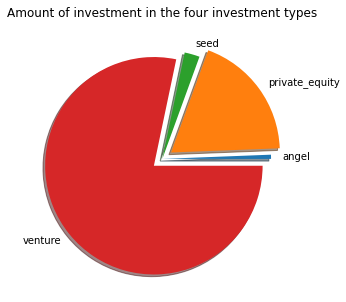

In [100]:
# Graph showing the total aount of investment in the four investment types
plt.figure(figsize=[5,5])
colors = ['lightskyblue', 'red', 'blue', 'green']
explode =(0,0.1,0,0.1) 
plt.pie(master_frame_T1['sum'],labels=master_frame_T1['funding_round_type'],explode = explode, shadow=True)
plt.title('Amount of investment in the four investment types')
plt.show()

In [144]:
#Lets have a look at the numbers for the above graph
master_frame_T1

,funding_round_type,sum
0,angel,4.659255e+09
1,private_equity,1.419254e+11
2,seed,1.698986e+10
3,venture,5.901262e+11


#### 5. Investment type analysis:

#### Now we can say that the representative amount would be the amount that is midway of all the investments concentrated at a point, considering there are a few extreme outliers. By this I mean that we can analyse the median of these amounts invested in these investment types to check for the representative value for each of the investment types. 

#### Let's have a look at the representative investment amounts for the four investment types - 'venture','angel','seed' and 'private_equity'. For this, we are going to check for the mean and median value of raised amounts for each of these investment types. I am going to check for which amount (mean or median) can be used as the representative value.

##### Let's have a look at the values of the representative amounts for these investment types and then plot the graph

In [102]:
print('Representative (Median) amount for seed (USD) :',round(master_frame[master_frame.funding_round_type == 'seed']['raised_amount_usd'].median()))
print('Representative (Mean) amount for seed (USD) :',round(master_frame[master_frame.funding_round_type == 'seed']['raised_amount_usd'].mean()))
print('Representative (Median) amount for venture (USD) :',round(master_frame[master_frame.funding_round_type == 'venture']['raised_amount_usd'].median()))
print('Representative (Mean) amount for venture (USD) :',round(master_frame[master_frame.funding_round_type == 'venture']['raised_amount_usd'].mean()))
print('Representative (Median) amount for angel (USD) :',round(master_frame[master_frame.funding_round_type == 'angel']['raised_amount_usd'].median()))
print('Representative (Mean) amount for angel (USD) :',round(master_frame[master_frame.funding_round_type == 'angel']['raised_amount_usd'].mean()))
print('Representative (Median) amount for private_equity (USD) :',round(master_frame[master_frame.funding_round_type == 'private_equity']['raised_amount_usd'].median()))
print('Representative (Mean) amount for private_equity (USD) :',round(master_frame[master_frame.funding_round_type == 'private_equity']['raised_amount_usd'].mean()))

Representative (Median) amount for seed (USD) : 275000
Representative (Mean) amount for seed (USD) : 719818
Representative (Median) amount for venture (USD) : 5000000
Representative (Mean) amount for venture (USD) : 11748949
Representative (Median) amount for angel (USD) : 400000
Representative (Mean) amount for angel (USD) : 958694
Representative (Median) amount for private_equity (USD) : 20000000
Representative (Mean) amount for private_equity (USD) : 73308593


#### From the above numbers, we can see there is a very high difference between the mean and the median value of each of the investment types. This is because of the extreme high outliers values that each of these investments have. Thus, for our analysis, we are going to consider the median as the representative amount.

#### According to our analysis, we have to check for investment amounts that are in 5 million to 15 million USD. Let's plot a line in our graph so that we can check for the investment types that are in our criteria

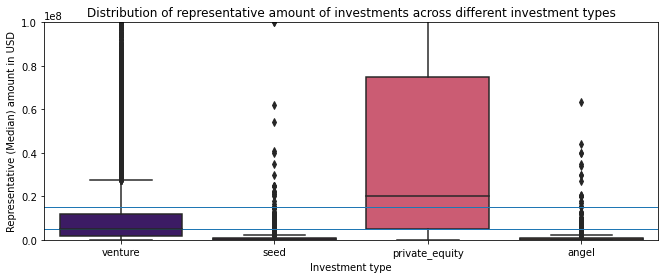

In [103]:
# Representative(median) across investment types
plt.figure(figsize=[11,4])
sns.boxplot(data=master_frame[master_frame['funding_round_type'].isin(['venture','seed','angel','private_equity'])],x="funding_round_type",y="raised_amount_usd",palette=('magma')).set_title('Distribution of representative amount of investments across different investment types')
plt.axhline(y=5000000, linewidth=1)
plt.axhline(y=15000000, linewidth=1)
plt.ylim(0,100000000)
plt.xlabel('Investment type')
plt.ylabel('Representative (Median) amount in USD')
plt.show()

##### From the above graph, we can see that 'venture' investment representative amount falls between the 5 and 15 million USD bucket that Spark Funds would be most interested in to invest. Seed and angel investments have a much lower representative amount compared to the investment bracket and private equity has a much higher representative amount

#### So now we are going to filter the master data with investment type 'venture' to proceed with our next analysis

In [104]:
# Filtering master frame with data having investment type 'venture' only
master_frame = master_frame[master_frame['funding_round_type'] =='venture']

In [105]:
#Checking for the volume of data in the master frame
master_frame.shape

(50228, 8)

#### Now let's have a look at the countries information in the dataset on where the investments were made the most

In [106]:
# Below is the list of total fundings received grouped by countries across all sectors for venture investment type
master_frame.groupby(by=['country_code'])['raised_amount_usd'].sum().sort_values(ascending=False)

country_code
USA    4.225108e+11
CHN    3.983542e+10
GBR    2.024563e+10
IND    1.439186e+10
CAN    9.583332e+09
           ...     
MCO    6.570000e+05
SAU    5.000000e+05
CMR    3.595610e+05
GTM    3.000000e+05
MMR    2.000000e+05
Name: raised_amount_usd, Length: 97, dtype: float64

#### 6. Top 9 country analysis:

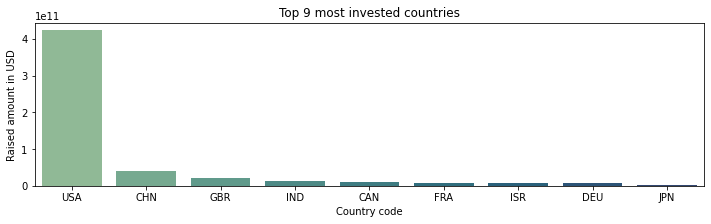

In [107]:
# Considering the top 9 Total investment, lets have a look at the graph as below 
plt.figure(figsize=[12,3])
top9 = master_frame.groupby(by='country_code').sum().sort_values('raised_amount_usd',ascending=False).iloc[:9,]
top9.reset_index(level=0,inplace=True)
sns.barplot(x=top9['country_code'],y=top9['raised_amount_usd'],palette=('crest')).set_title('Top 9 most invested countries')
plt.ylabel('Raised amount in USD')
plt.xlabel('Country code')
plt.show()

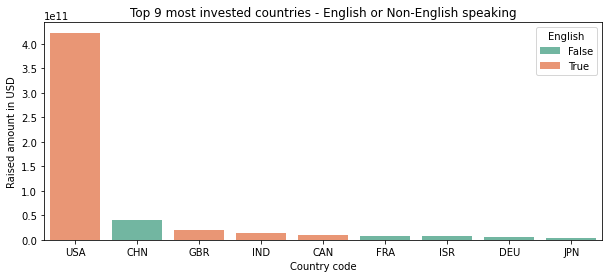

In [108]:
# Check for countries where one of the official langiage is English
plt.figure(figsize=[10,4])
top9['English'] = top9['country_code'].isin(['USA','GBR','IND','CAN'])
chk = sns.barplot(x='country_code',y='raised_amount_usd',hue='English',data=top9,dodge=False,palette='Set2').set_title('Top 9 most invested countries - English or Non-English speaking')
plt.ylabel('Raised amount in USD')
plt.xlabel('Country code')
plt.show()

#### Now that we have the investment type and country analysed for Spark Funds investment, let's have a look at the categories that are available in the master frame dataset

In [109]:
# Checking null value in the category list
master_frame[master_frame['category_list'].isnull() == True].head(3)

,company_permalink,funding_round_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code
99,/organization/123feng-com,/funding-round/9d83084d87dc63a309c9a6fe9bf59d1b,venture,13000000.0,123Feng.Com,NaN,operating,CHN
133,/organization/17-media,/funding-round/f8ffde9fa822843ac6ea9b66cc615df1,venture,10000000.0,17 Media,NaN,operating,NaN
181,/organization/1mxians,/funding-round/6950448f81c6706abe61f659e15a7c87,venture,15000000.0,1mxians,NaN,operating,CHN


In [110]:
# Checking null value % in the category list
round((master_frame['category_list'].isnull().sum())/(master_frame['category_list'].count())*100)

1

##### So we can see that 1% of the master frame dataset have no category information

#### For our analysis we can either drop the null rows for the Category column or keep it and continue with our analysis. For now, we are going to keep the null values and continue with our analysis

#### Let's now derive a new column 'primary_sector' from 'category_list' based on the first value in the 'category_list' column before the separator '|'

In [111]:
# Deriving new column(primary_sector) based on existing column(category_list)
master_frame['primary_sector'] = master_frame['category_list'].map(lambda x:x.split('|')[0] if type(x) == str else x)

In [112]:
# Modifying the mapping dataset into a two dimentional table structure using melt function to map with master frame dataset
mapping = pd.melt(mapping, id_vars =['category_list'], value_vars =['Automotive & Sports','Blanks','Cleantech / Semiconductors','Entertainment','Health','Manufacturing','News, Search and Messaging','Others','Social, Finance, Analytics, Advertising']) 

In [113]:
# Keeping the ones with value 1 so that all the zeros are removed from the mapping table
mapping = mapping[mapping.value == 1]

In [114]:
# In the mapping dataset, we can see there are a few values that are not correct like 'Knowledge Ma0gement' should be 'Knowledge Management
# So we see a common error of having '0' in place of 'na' in between words. We also have to make sure that 0 is there where it should be.
# Replacing '0' by 'na' in the category_list column
mapping['category_list'] = mapping['category_list'].str.replace('0','na',regex=True)
# Replacing '2.na' by '2.0' because 2.0 was the actual string that got replaced by na in place of '0'
mapping['category_list'] = mapping['category_list'].str.replace('2.na','2.0',regex=True)

##### While we are replacing the incorrect '0' in the string, there are a few column values where the replacement needs to be in the correct case as well in order to map the value with the masterframe. For example, 'Nanotechnology' is a catogory in master frame dataset but that is 'nanotechnology' in the category in mapping dataset. This case of the first 'n' needs to be corrected before mapping the values to avoid incorrect mapping

In [115]:
#Updating column values with mapping values from master frame dataset to map properly
mapping['category_list'] = mapping['category_list'].str.replace('nanotechnology','Nanotechnology',regex=True)
mapping['category_list'] = mapping['category_list'].str.replace('natural','Natural',regex=True)
mapping['category_list'] = mapping['category_list'].str.replace('navigation','Navigation',regex=True)

In [116]:
# Dropping the value column as we do not need it for our analysis
mapping.drop(columns='value',inplace=True)

In [117]:
# Renaming the category list column in mapping table to primary_sector to merge with the master frame dataset
mapping = mapping.rename(columns={'category_list':'primary_sector'})

In [118]:
# Merging the master dataset with the mapping dataset to get the main sector information in the master frame dataset for the companies
master_frame = master_frame.merge(mapping,how='left',on='primary_sector')

In [119]:
# Renaming the variable column in the master dataset to main_sector
master_frame = master_frame.rename(columns={'variable':'main_sector'})

In [120]:
# Find the number of unique primary sectors (Categories) in master_frame database
master_frame['primary_sector'].nunique()

607

In [121]:
# Find the number of unique categories in mapping dataset
mapping['primary_sector'].nunique()

687

In [122]:
# Find the number of unique sectors in mapping dataset
mapping['variable'].nunique()

9

##### It is to be noted that 'Blank' is also one sector in the above 9 Sectors. The main sectors are 8. The companies where no mapping were found are going to be dropped from further analysis datasets

#### 7. Top 3 English speaking countries analysis:

##### Now we have the top three English speaking countries for the venture investment type. Let's create three subsets of master dataframe for each of these countries for further analysis

#### Since we are analysing the eight main sectors distribution of investments, we are going to consider the eight main sectors only that are in the mapping table. So, we will drop the null and blank values in the main sector before proceeding with our sector analysis. Also, the amount bucket is in the range of 5 million to 15 million USD

In [123]:
#Country 1: Top English speaking country with most investments in venture
D1 = master_frame[(master_frame['country_code'] == 'USA')&(master_frame['raised_amount_usd'] >= 5000000)&(master_frame['raised_amount_usd'] <= 15000000)]
D1 = D1[~D1['main_sector'].isnull()]
D1 = D1[D1['main_sector'] != 'Blanks']
#Country 2: Second top English speaking country with most investments in venture
D2 = master_frame[(master_frame['country_code'] == 'GBR')&(master_frame['raised_amount_usd'] >= 5000000)&(master_frame['raised_amount_usd'] <= 15000000)]
D2 = D2[~D2['main_sector'].isnull()]
D2 = D2[D2['main_sector'] != 'Blanks']
#Country 3: Third top English speaking country with most investments in venture
D3 = master_frame[(master_frame['country_code'] == 'IND')&(master_frame['raised_amount_usd'] >= 5000000)&(master_frame['raised_amount_usd'] <= 15000000)]
D3 = D3[~D3['main_sector'].isnull()]
D3 = D3[D3['main_sector'] != 'Blanks']

In [124]:
# Checking the counts and amounts of each countries
usa_count = D1['funding_round_permalink'].count()
gbr_count = D2['funding_round_permalink'].count()
ind_count = D3['funding_round_permalink'].count()
usa_amount_sum = D1['raised_amount_usd'].sum()
gbr_amount_sum = D2['raised_amount_usd'].sum()
ind_amount_sum = D3['raised_amount_usd'].sum()

In [125]:
# Checking the counts and amounts of each countries
print('Total count of investment in USA is: ', usa_count)
print('Total count of investment in GBR is: ', gbr_count)
print('Total count of investment in IND is: ', ind_count)
#---------------------------------------------------------------------------------------------------------------
print()
print('Total amount of investment in USA is: ', usa_amount_sum)
print('Total amount of investment in GBR is: ', gbr_amount_sum)
print('Total amount of investment in IND is: ', ind_amount_sum)
#---------------------------------------------------------------------------------------------------------------

Total count of investment in USA is:  12063
Total count of investment in GBR is:  621
Total count of investment in IND is:  328

Total amount of investment in USA is:  107757097294.0
Total amount of investment in GBR is:  5379078691.0
Total amount of investment in IND is:  2949543602.0


#### 8. Sector analysis:

In [126]:
# Top three sectors in USA that are heavily invested (Count based analysis)
D1['main_sector'].value_counts().head(3)

Others                                     2950
Social, Finance, Analytics, Advertising    2714
Cleantech / Semiconductors                 2350
Name: main_sector, dtype: int64

In [127]:
# Top three sectors in GBR that are heavily invested (Count based analysis)
D2['main_sector'].value_counts().head(3)

Others                                     147
Social, Finance, Analytics, Advertising    133
Cleantech / Semiconductors                 130
Name: main_sector, dtype: int64

In [128]:
# Top three sectors in IND that are heavily invested (Count based analysis)
D3['main_sector'].value_counts().head(3)

Others                                     110
Social, Finance, Analytics, Advertising     60
News, Search and Messaging                  52
Name: main_sector, dtype: int64

In [129]:
#Now let's find out the companies with the highest investment in USA in two of the most heavily invested sectors
D11 = D1[D1.main_sector == 'Others'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()
D12 = D1[D1.main_sector == 'Social, Finance, Analytics, Advertising'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()

In [130]:
#Now let's find out the companies with the highest investment in GBR in two of the most heavily invested sectors
D22 = D2[D2.main_sector == 'Others'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()
D23 = D2[D2.main_sector == 'Social, Finance, Analytics, Advertising'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()

In [131]:
#Now let's find out the companies with the highest investment in IND in two of the most heavily invested sectors
D33 = D3[D3.main_sector == 'Others'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()
D34 = D3[D3.main_sector == 'Social, Finance, Analytics, Advertising'].groupby(by=['company_permalink','name','status'])['raised_amount_usd'].agg(['sum','count']).reset_index()

In [132]:
#Company with the highest investment in most invested sector in USA
print('Company with the highest investment in most invested sector in USA :',D11[D11['sum'] == D11['sum'].max()]['name'])
#Company with the highest investment in second most invested sector in USA
print('Company with the highest investment in second most invested sector in USA :',D12[D12['sum'] == D12['sum'].max()]['name'])
#Company with the highest investment in most invested sector in GBR
print('Company with the highest investment in most invested sector in GBR :',D22[D22['sum'] == D22['sum'].max()]['name'])
#Company with the highest investment in second most invested sector in GBR
print('Company with the highest investment in second most invested sector in GBR :',D23[D23['sum'] == D23['sum'].max()]['name'])
#Company with the highest investment in most invested sector in IND
print('Company with the highest investment in most invested sector in IND :',D33[D33['sum'] == D33['sum'].max()]['name'])
#Company with the highest investment in second most invested sector in IND
print('Company with the highest investment in second most invested sector in IND :',D34[D34['sum'] == D34['sum'].max()]['name'])

Company with the highest investment in most invested sector in USA : 1942    Virtustream
Name: name, dtype: object
Company with the highest investment in second most invested sector in USA : 1430    SST Inc. (Formerly ShotSpotter)
Name: name, dtype: object
Company with the highest investment in most invested sector in GBR : 35    Electric Cloud
Name: name, dtype: object
Company with the highest investment in second most invested sector in GBR : 21    Celltick Technologies
Name: name, dtype: object
Company with the highest investment in most invested sector in IND : 27    FirstCry.com
Name: name, dtype: object
Company with the highest investment in second most invested sector in IND : 31    Manthan Systems
Name: name, dtype: object


In [133]:
#Let's have a look at the company getting the most investment in USA in Others sector
D11[D11['sum'] == D11['sum'].max()]

,company_permalink,name,status,sum,count
1942,/organization/virtustream,Virtustream,acquired,64300000.0,6


In [134]:
#Let's have a look at the company getting the most investment in USA in Social, Finance, Analytics, Advertising sector
D12[D12['sum'] == D12['sum'].max()]

,company_permalink,name,status,sum,count
1430,/organization/shotspotter,SST Inc. (Formerly ShotSpotter),operating,67933006.0,7


In [135]:
#Let's have a look at the company getting the most investment in GBR in Others sector
D22[D22['sum'] == D22['sum'].max()]

,company_permalink,name,status,sum,count
35,/organization/electric-cloud,Electric Cloud,operating,37000000.0,4


In [136]:
#Let's have a look at the company getting the most investment in GBR in Social, Finance, Analytics, Advertising sector
D23[D23['sum'] == D23['sum'].max()]

,company_permalink,name,status,sum,count
21,/organization/celltick-technologies,Celltick Technologies,operating,37500000.0,4


In [137]:
#Let's have a look at the company getting the most investment in IND in Others sector
D33[D33['sum'] == D33['sum'].max()]

,company_permalink,name,status,sum,count
27,/organization/firstcry-com,FirstCry.com,operating,39000000.0,3


In [138]:
#Let's have a look at the company getting the most investment in IND in Social, Finance, Analytics, Advertising sector
D34[D34['sum'] == D34['sum'].max()]

,company_permalink,name,status,sum,count
31,/organization/manthan-systems,Manthan Systems,operating,50700000.0,4


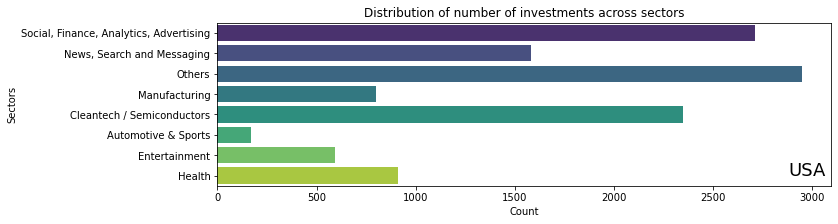

In [139]:
# Graph plot showing investments across sectors in USA
plt.figure(figsize=[11,3])
sns.countplot(data=D1,y="main_sector",palette=('viridis')).set_title('Distribution of number of investments across sectors')
#plt.xticks(rotation = 75)
plt.text(2880,7,'USA',fontsize = 18)
plt.ylabel('Sectors')
plt.xlabel('Count')
plt.show()

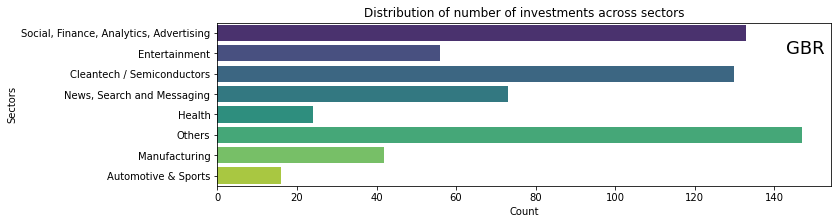

In [140]:
# Graph plot showing investments across sectors in GBR
plt.figure(figsize=[11,3])
sns.countplot(data=D2,y="main_sector",palette=('viridis')).set_title('Distribution of number of investments across sectors')
plt.text(143,1,'GBR',fontsize = 18)
plt.ylabel('Sectors')
plt.xlabel('Count')
plt.show()

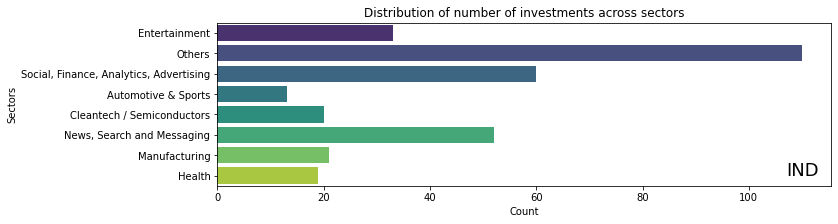

In [141]:
# Graph plot showing investments across sectors in IND
plt.figure(figsize=[11,3])
sns.countplot(data=D3,y="main_sector",palette=('viridis')).set_title('Distribution of number of investments across sectors')
plt.text(107,7,'IND',fontsize = 18)
plt.ylabel('Sectors')
plt.xlabel('Count')
plt.show()

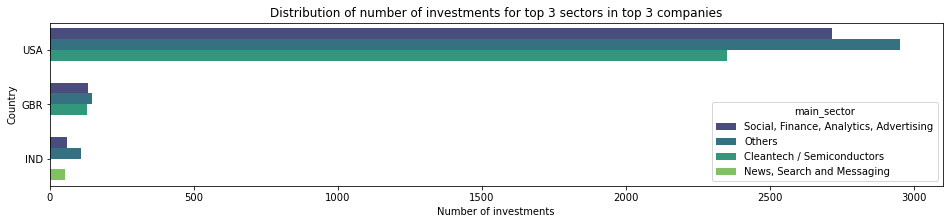

In [142]:
# Graph showing top 3 countries with their top 3 investment sectors
D1U = D1[D1['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]
D2G = D2[D2['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]
D3I = D3[D3['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging'])]
DD3 = pd.concat([D1U,D2G,D3I])
plt.figure(figsize=(16,3))
sns.countplot(y='country_code', hue="main_sector", data=DD3,palette=('viridis')).set_title('Distribution of number of investments for top 3 sectors in top 3 companies')
plt.xlabel('Number of investments')
plt.ylabel('Country')
plt.show()

#### 9. Data quality analysis and assumptions:

##### The data in companies dataset has a considerable amount of null values for a few columns. Around 30% of the data do not have the column value for Founded date. More than 10% have null values in city, country code, region and state code. I dropped the null values as and when the analysis requirement demanded. There was another issue in the data, the case sensitivity. The key identifier in this dataframe is company permalink which has mixed cases. I modified the case to lower so that it can be one single case that can be keyed to another dataframe. In this case, it is the rounds2 dataset. 

##### The data in the rounds2 dataset has also a large number of null values in some columns. The funding round code has more than 70% null values and the raised amount is also 17% null. I dropped the null values as and when the analysis requirement demanded. The case sensitive issue was in this dataframe as well for the key - company permalink. I changed it to lower case so that is can be mapped with the companies dataset and work on the analysis.

##### The columns were not all required for our analysis. I joined the companies and rounds2 dataset to get all the columns according to a common key - company permalink. But for my targeted analysis, I needed to keep only a few columns and drop the rest. I kept the company permalink column because it is the key to a specific company and I needed it to analyse the data. I kept the funding round permalink column becasue it specifies the unique transactions for each raised amount for each company. This helped me in the counts analysis for each country or Industrial sector. I kept the funding round type to find the funding type most companies were interested in. I kept the raised amount to calculate the median and total values of amount raised, which was part of the analysis. The name column for company to check for the companies receiving the highest funds for a country and a sector. The category column to analyse the Industrial sector. The country code column to analyse the country.   

##### The mapping dataset had error in the category name. A few values were noticed having '0' in place of 'na' or 'Na'. These values were to be replaced for the mapping to the Industrial sectors. Also, at some places, the '0' was supposed to be there. Needed to make sure that not all '0's are getting replaced while correcting the value. It should be replaced only where there are incorrect values for the category.